# User Identification From Walking Activity Data Set

Author: Miha Gazvoda  

# Summary

My goal was to identify a user from their wearable device data using machine learning. The data consisted of 22 users with different time durations - from 30 to 700 seconds. With simple features calculated from all three acceleration components plus its magnitude (based on a two-second non-overlapping time window),  I achieved around 0.75 non-weighted average precision, recall, and f1 score. The algorithm I used was KNN with k=1. Logistic regression with grid-searched L2 parameters performed worse. I believe metrics can be improved by putting more effort into signal preprocessing, feature engineering, and model selection.  


In [1]:
import pandas as pd
import seaborn as sns
import hiplot as hip
import matplotlib.pyplot as plt

from glob import glob
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report
from common import read_participant_csv, add_acceleration_magnitude, add_time_group, calculate_attributes 

# Import file

I didn't want to lose time to programmatically unzip the file from the [URL](https://archive.ics.uci.edu/ml/datasets/User+Identification+From+Walking+Activity). Instead, I manually downloaded it to the `data` folder.

In [2]:
files = glob("data/*.csv")
df = pd.concat(map(read_participant_csv, files))

# Prepare features

1. With `add_acceleration_magnitude` I calculated the magnitude of acceleration named `r`. I plotted the acceleration magnitude per user using Altair.
 <details>
  <summary>Click here to see the code</summary>
  <pre>
import altair as alt
(alt
     .Chart(df.query('time_step < 2').pipe(add_acceleration_magnitude))
     .mark_point()
     .encode(x='time_step', y='r')
     .properties(width=600,height=100)
     .facet(facet='participant:N', columns=1))
</pre>
</details> 

2.  I added a column `time_group` calculated as integer division between time and an input variable `time_window`. The column was used as a time window for calculating features.

    * Users have different durations of tracked data so this meant `time_window` shouldn't be too long because we won't get enough observations for some users. (I checked this with `df_ready.groupby('participant').size()`.) On the other hand, a shorter time window meant more data points but noisier features. Plus, with a shorter window, we could classify users faster! 
    
    * Improvement would be the overlap of windows. This way we could get more features per user (which would be independent, but anyway worth a try).
    
    * `time_window` could be used as a meta parameter for grid search - combined with our preferences, of course. 
    
    * The last time window is always shorter than the previous ones. Imagine the user has 7.3 units of time. If we use time window 2, the last will be only 1.3 long.
    
    * It could happen that the device would sample with low frequency. In this case, our time window would have a low number of points which is not so suitable for feature calculation. To avoid that, we could use a number of samples instead of a time window. So, using first `n` points instead of all the points from the first `time_window`. 

3. Due to the time limit, I skipped the whole signal preprocessing part (smoothing, removing outliers, ...). It would for sure offer improvement in robustness and quality of features.

4. I calculated the most basic attributes which are meant mostly as a showcase. Possible improvements: Fourier transform features, (auto) correlations/covariances, kurtosis, skewness...

In [3]:
df_ready = (df 
    .pipe(add_acceleration_magnitude) 
    .pipe(add_time_group, time_window=2) 
    .pipe(calculate_attributes))

## Observe features

Note that this is not completely correct since we are looking at the whole data.  

[Hiplot](https://ai.facebook.com/blog/hiplot-high-dimensional-interactive-plots-made-easy/) enables a user-friendly, interactive way of exploring features. 

In [4]:
(hip
     .Experiment
     .from_iterable(df_ready.to_dict(orient='records'))
     .display())

<IPython.core.display.Javascript object>

# Modeling

Note: I never shuffled the data. This way I ensured cross-validation folds have features from neighboring time windows and that the test data happens later than the training (of course, this is not true for CV).

Because users have a different number of observations (class imbalance), I used precision, recall, and f1 score besides accuracy. I didn't want to weigh one person over another, I used `average='macro'` setting, ie. unweighted average.

Stratification was used to split data into train and test sets.  On the training data, I used stratified cross-validation. It would make even more sense to use a stratified time series split since in real life we would predict for future cases. However, it would decrease training data used compared to standard k-fold CV. 

The first model I created was a dummy one to set a benchmark.

Then I used k-nearest neighbors (also tried logistic regression which performed worse). With a CV grid search on a number of neighbors, I found out that `k=1` model performs the best (regarding f1 score). I could also grid search different distances. With more time on hand, I would try more machine learning algorithms. 

I used the best-performing setting to test it on unseen test data. It performed even better. I suspect due to more training cases. What surprised me is that despite some users having fewer data points, they don't perform worse. That kept me from using any tricks for handling unbalanced datasets. (I used different class weights when trying logistic regression.)

We only have data for 22 people. In the case of productizing the feature, ie. using it on way more people, KNN probably wouldn't be suitable since it gets computationally expensive. It would also make sense to combine acceleration features with some others (GPS location, for example).

In [5]:
SCORING = {'accuracy': make_scorer(accuracy_score), 
           "precision": make_scorer(precision_score, average="macro", zero_division=1), 
           "recall": make_scorer(recall_score, average="macro", zero_division=1), 
           "f1": make_scorer(f1_score, average="macro")}
N_SPLITS = 5
REFIT = 'f1'

In [7]:
X = df_ready.drop(['participant'], axis=1).values
y = df_ready.participant.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 

## Dummy classifier

In [8]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", DummyClassifier())
])

dummy_model = GridSearchCV(
    estimator=pipe, 
    param_grid={'model__strategy': ['stratified', 'most_frequent', 'uniform']},
    scoring=SCORING,
    refit=REFIT,
    cv=StratifiedKFold(n_splits=N_SPLITS)
)

dummy_model.fit(X_train, y_train);

pd.DataFrame(dummy_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__strategy,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.001961,0.000629,0.004864,0.001241,stratified,{'model__strategy': 'stratified'},0.090909,0.090909,0.066845,0.077540,...,0.008291,2,0.054312,0.050052,0.034128,0.039121,0.048996,0.045322,0.007489,1
1,0.001586,0.000196,0.003469,0.000408,most_frequent,{'model__strategy': 'most_frequent'},0.144385,0.144385,0.144385,0.141711,...,0.000000,3,0.011470,0.011470,0.011470,0.011284,0.011497,0.011438,0.000078,3
2,0.001414,0.000032,0.003868,0.000921,uniform,{'model__strategy': 'uniform'},0.050802,0.048128,0.045455,0.045455,...,0.008712,1,0.044051,0.042206,0.037927,0.037818,0.036899,0.039780,0.002818,2


## KNN

In [9]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", KNeighborsClassifier())
])

mod = GridSearchCV(
    estimator=pipe, 
    param_grid={'model__n_neighbors': list(range(1,11))}, 
    scoring=SCORING,
    refit=REFIT,
    cv=StratifiedKFold(n_splits=N_SPLITS),
    n_jobs=-1
)

mod.fit(X_train, y_train);

pd.DataFrame(mod.cv_results_).sort_values(['rank_test_f1'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.006469,0.001009,0.045228,0.001407,1,{'model__n_neighbors': 1},0.745989,0.754011,0.711230,0.762032,...,0.039370,2,0.696876,0.692544,0.602484,0.733210,0.642715,0.673566,0.045750,1
3,0.004806,0.000742,0.059109,0.004822,4,{'model__n_neighbors': 4},0.729947,0.754011,0.724599,0.735294,...,0.026024,1,0.648068,0.698568,0.645170,0.693449,0.674141,0.671879,0.022195,2
4,0.004120,0.000295,0.059301,0.005087,5,{'model__n_neighbors': 5},0.719251,0.756684,0.719251,0.729947,...,0.021551,4,0.646577,0.694976,0.636431,0.683972,0.658693,0.664130,0.022136,3
2,0.003901,0.000762,0.056880,0.004711,3,{'model__n_neighbors': 3},0.737968,0.751337,0.719251,0.740642,...,0.036118,3,0.646998,0.696828,0.626216,0.696517,0.653230,0.663958,0.028170,4
6,0.004240,0.000411,0.052971,0.002458,7,{'model__n_neighbors': 7},0.705882,0.762032,0.711230,0.751337,...,0.032677,6,0.621817,0.677318,0.612986,0.701736,0.645741,0.651920,0.033427,5
7,0.004106,0.000133,0.052445,0.001369,8,{'model__n_neighbors': 8},0.700535,0.745989,0.703209,0.764706,...,0.029963,8,0.610588,0.652012,0.615435,0.705233,0.653183,0.647290,0.033989,6
5,0.004964,0.000950,0.057461,0.002898,6,{'model__n_neighbors': 6},0.713904,0.751337,0.724599,0.745989,...,0.024675,7,0.637490,0.657203,0.620438,0.689189,0.629605,0.646785,0.024423,7
8,0.004840,0.000491,0.054622,0.001630,9,{'model__n_neighbors': 9},0.697861,0.756684,0.703209,0.751337,...,0.024947,9,0.616016,0.669937,0.608803,0.664093,0.666434,0.645057,0.026818,8
1,0.005408,0.001878,0.049605,0.003276,2,{'model__n_neighbors': 2},0.727273,0.727273,0.705882,0.729947,...,0.030571,5,0.652797,0.668227,0.616034,0.674824,0.613143,0.645005,0.025860,9
9,0.004564,0.000528,0.041546,0.011196,10,{'model__n_neighbors': 10},0.692513,0.754011,0.700535,0.743316,...,0.026514,10,0.614480,0.663429,0.576038,0.612326,0.641785,0.621611,0.029562,10


## Predicting on test data

<AxesSubplot:>

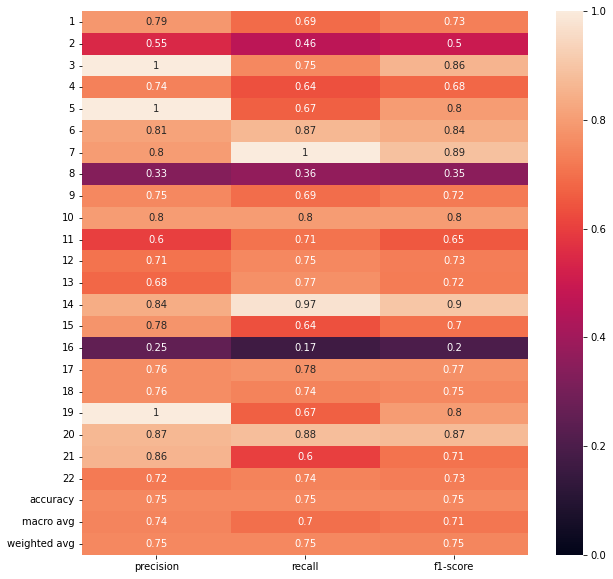

In [10]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=1))
])

y_pred = pipe.fit(X_train, y_train).predict(X_test)

clf_report = classification_report(y_test, y_pred,
                                   target_names=list(set(y_test)),
                                   output_dict=True)

plt.figure(figsize = (10,10))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, vmin=0, vmax=1)